# Parkinson's Disease Detection from Speech Features

## Overview
This notebook implements a machine learning pipeline to classify Parkinson's Disease (PD) from speech/voice features.

### Dataset Information
The dataset contains **752 speech features** extracted from voice recordings, organized into the following categories:

| Category | Description | # Features |
|----------|-------------|------------|
| **Baseline Features** | PPE, DFA, RPDE, Jitter, Shimmer, Harmonicity | ~22 |
| **Intensity Parameters** | Min, Max, Mean intensity | 3 |
| **Formant Frequencies** | F1-F4 formant frequencies | 4 |
| **Bandwidth Parameters** | B1-B4 bandwidth | 4 |
| **Vocal Fold (GNE/VFER/IMF)** | Glottal features | ~22 |
| **MFCC Features** | Mel-frequency cepstral coefficients | ~130 |
| **Wavelet Features** | Discrete wavelet transform features | ~182 |
| **TQWT Features** | Tunable Q-factor wavelet transform | ~432 |

**Target**: `class` (0 = Healthy Control, 1 = Parkinson's Disease)

## 1. Import Libraries and Load Data

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load the dataset
# Row 0 contains feature categories, Row 1 contains actual column names
filepath = 'd:/Parkinson/datasets/speech/parkinson+s+disease+classification/pd_speech_features.csv'

# Load categories (first row)
categories_df = pd.read_csv(filepath, nrows=1, header=None)

# Load actual data (skip first row which has categories)
df = pd.read_csv(filepath, header=1)

print(f"Dataset Shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1] - 2}")
print(f"\nColumn names (first 10): {list(df.columns[:10])}")
print(f"Column names (last 5): {list(df.columns[-5:])}")

Dataset Shape: (756, 755)
Number of samples: 756
Number of features: 753

Column names (first 10): ['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter']
Column names (last 5): ['tqwt_kurtosisValue_dec_33', 'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35', 'tqwt_kurtosisValue_dec_36', 'class']


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Basic statistics
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

# Data types
print(f"\nData types:")
print(df.dtypes.value_counts())

# Missing values
missing = df.isnull().sum().sum()
print(f"\nMissing values: {missing}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Display first few rows
df.head()

DATASET OVERVIEW

Data types:
float64    749
int64        6
Name: count, dtype: int64

Missing values: 0
Duplicate rows: 1


,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


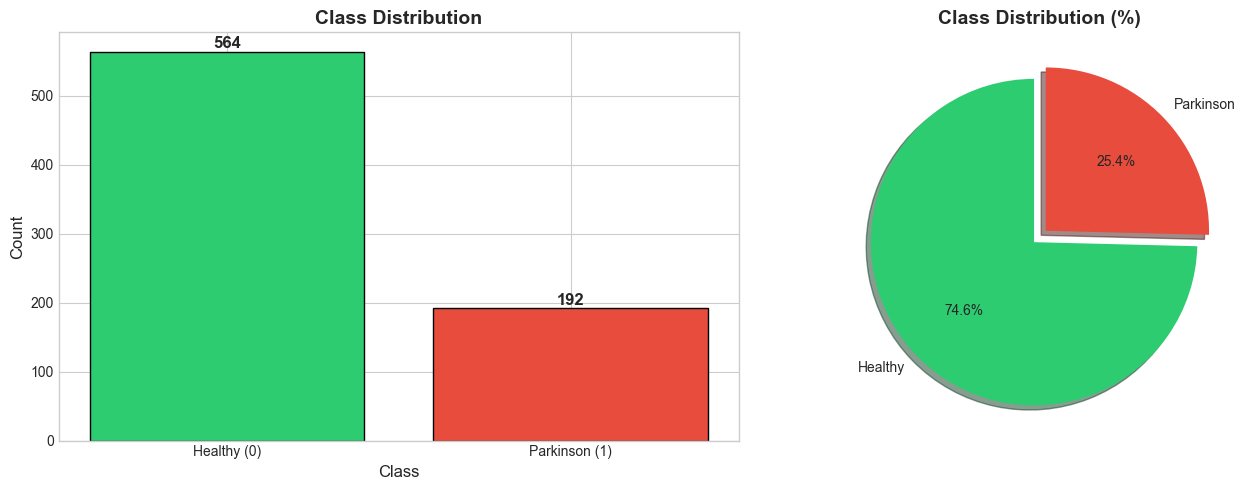


Class Distribution:
  Healthy Controls (0): 192 (25.4%)
  Parkinson's Disease (1): 564 (74.6%)

⚠️ Note: Dataset is IMBALANCED (ratio ~1:3)


In [4]:
# Class Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
class_counts = df['class'].value_counts()
colors = ['#2ecc71', '#e74c3c']
ax1 = axes[0]
bars = ax1.bar(['Healthy (0)', 'Parkinson (1)'], class_counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
for bar, count in zip(bars, class_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', fontsize=12, fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(class_counts.values, labels=['Healthy', 'Parkinson'], autopct='%1.1f%%',
        colors=colors, explode=(0.05, 0.05), shadow=True, startangle=90)
ax2.set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nClass Distribution:")
print(f"  Healthy Controls (0): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
print(f"  Parkinson's Disease (1): {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")
print(f"\n⚠️ Note: Dataset is IMBALANCED (ratio ~1:3)")

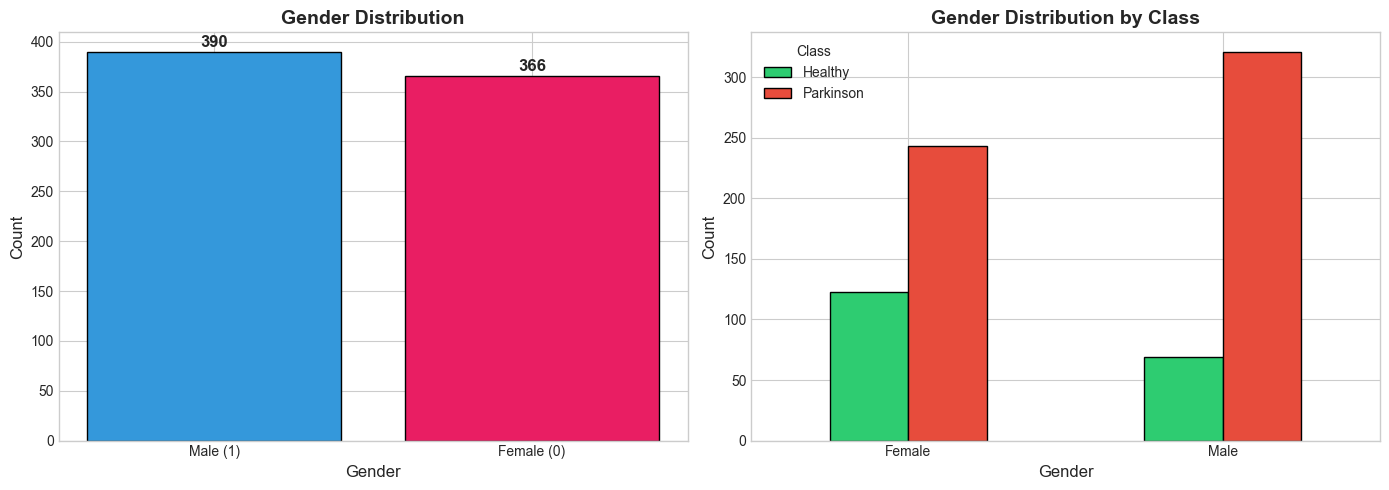

In [5]:
# Gender distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall gender distribution
gender_counts = df['gender'].value_counts()
ax1 = axes[0]
bars = ax1.bar(['Male (1)', 'Female (0)'], gender_counts.values, color=['#3498db', '#e91e63'], edgecolor='black')
ax1.set_xlabel('Gender', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Gender Distribution', fontsize=14, fontweight='bold')
for bar, count in zip(bars, gender_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', fontsize=12, fontweight='bold')

# Gender by class
ax2 = axes[1]
gender_class = pd.crosstab(df['gender'].map({0: 'Female', 1: 'Male'}), 
                           df['class'].map({0: 'Healthy', 1: 'Parkinson'}))
gender_class.plot(kind='bar', ax=ax2, color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax2.set_xlabel('Gender', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Gender Distribution by Class', fontsize=14, fontweight='bold')
ax2.legend(title='Class')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [6]:
# Define feature groups based on the dataset structure
feature_groups = {
    'Baseline (Jitter/Shimmer)': ['PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'meanPeriodPulses', 
                                  'stdDevPeriodPulses', 'locPctJitter', 'locAbsJitter', 'rapJitter', 
                                  'ppq5Jitter', 'ddpJitter', 'locShimmer', 'locDbShimmer', 'apq3Shimmer', 
                                  'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer', 'meanAutoCorrHarmonicity',
                                  'meanNoiseToHarmHarmonicity', 'meanHarmToNoiseHarmonicity'],
    'Intensity': ['minIntensity', 'maxIntensity', 'meanIntensity'],
    'Formant Frequencies': ['f1', 'f2', 'f3', 'f4'],
    'Bandwidth': ['b1', 'b2', 'b3', 'b4'],
    'Vocal Fold (GQ/GNE/VFER/IMF)': [col for col in df.columns if col.startswith(('GQ', 'GNE', 'VFER', 'IMF'))],
    'MFCC': [col for col in df.columns if 'MFCC' in col or 'delta' in col.lower() or 'Log_energy' in col],
    'Wavelet': [col for col in df.columns if any(x in col for x in ['Ea', 'Ed_', 'det_entropy', 'det_TKEO', 
                                                                     'app_entropy', 'app_det_TKEO', 'app_TKEO',
                                                                     'Ed2', 'det_LT', 'app_LT'])],
    'TQWT': [col for col in df.columns if col.startswith('tqwt')]
}

# Count features per group
print("Feature Groups Summary:")
print("=" * 50)
for group, features in feature_groups.items():
    valid_features = [f for f in features if f in df.columns]
    print(f"{group:40s}: {len(valid_features)} features")

Feature Groups Summary:
Baseline (Jitter/Shimmer)               : 21 features
Intensity                               : 3 features
Formant Frequencies                     : 4 features
Bandwidth                               : 4 features
Vocal Fold (GQ/GNE/VFER/IMF)            : 22 features
MFCC                                    : 84 features
Wavelet                                 : 182 features
TQWT                                    : 432 features


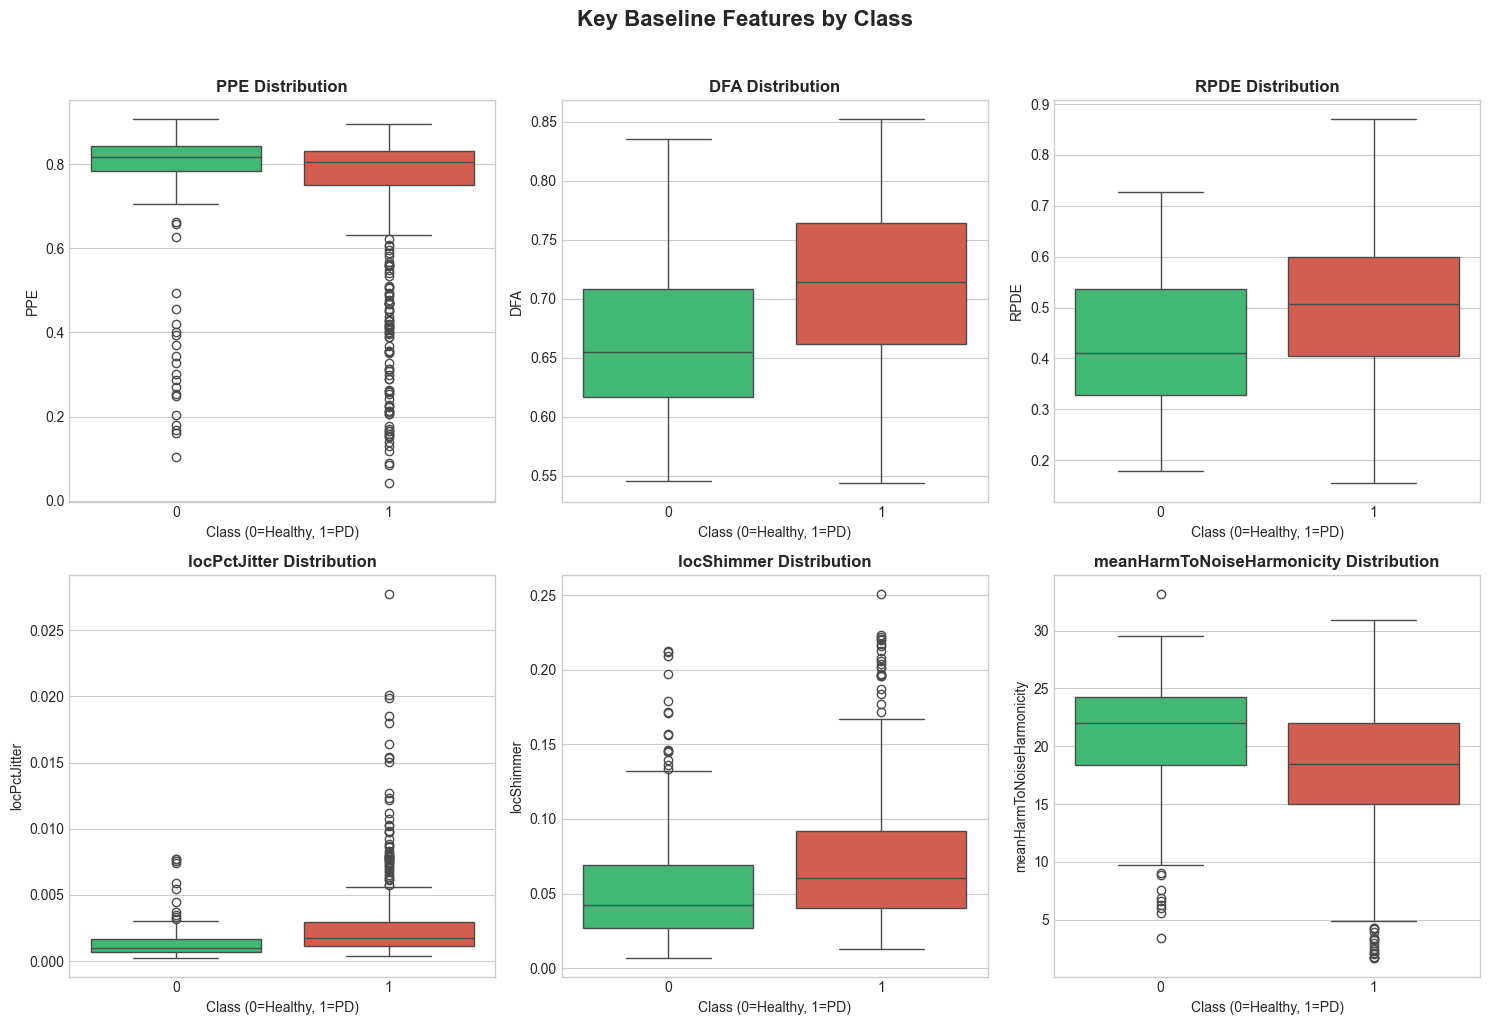

In [7]:
# Visualize key baseline features by class
key_features = ['PPE', 'DFA', 'RPDE', 'locPctJitter', 'locShimmer', 'meanHarmToNoiseHarmonicity']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, feature in zip(axes, key_features):
    if feature in df.columns:
        sns.boxplot(x='class', y=feature, data=df, ax=ax, palette=['#2ecc71', '#e74c3c'])
        ax.set_xlabel('Class (0=Healthy, 1=PD)', fontsize=10)
        ax.set_ylabel(feature, fontsize=10)
        ax.set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')

plt.suptitle('Key Baseline Features by Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

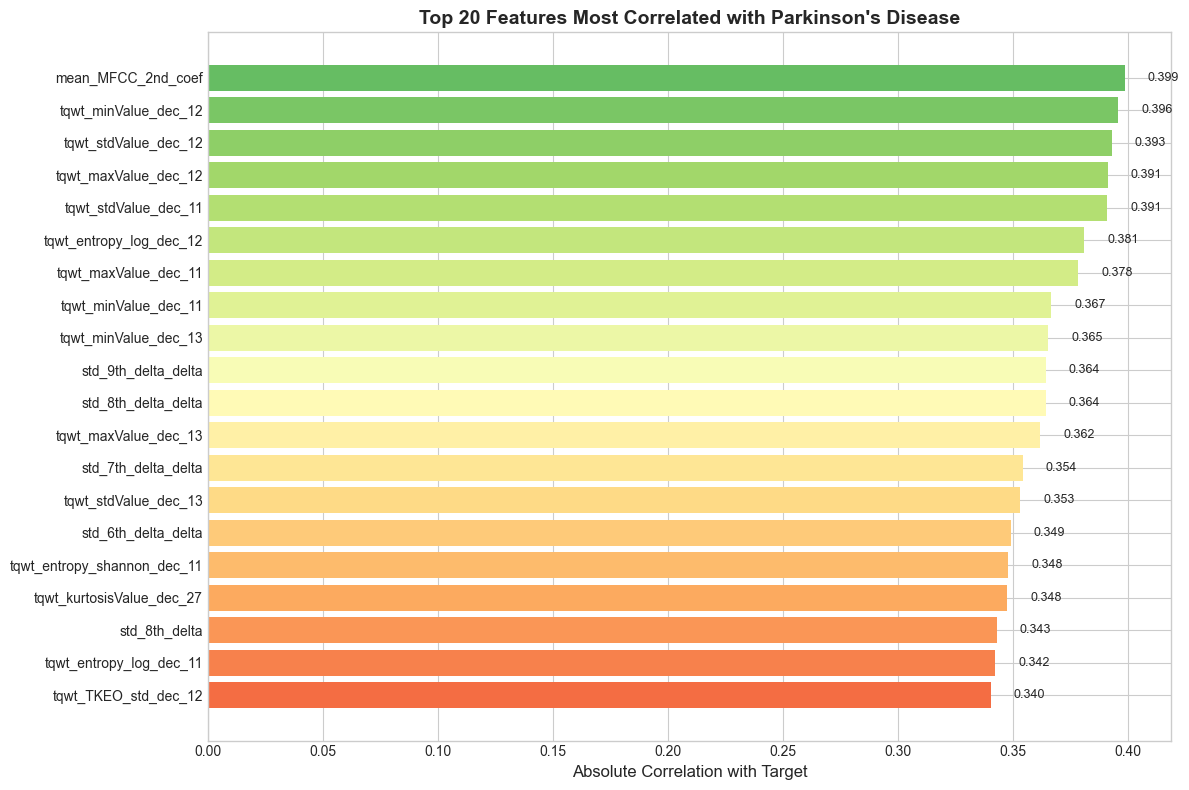


Top 10 features correlated with Parkinson's Disease:
 1. mean_MFCC_2nd_coef                      : 0.3987
 2. tqwt_minValue_dec_12                    : 0.3957
 3. tqwt_stdValue_dec_12                    : 0.3930
 4. tqwt_maxValue_dec_12                    : 0.3913
 5. tqwt_stdValue_dec_11                    : 0.3911
 6. tqwt_entropy_log_dec_12                 : 0.3810
 7. tqwt_maxValue_dec_11                    : 0.3785
 8. tqwt_minValue_dec_11                    : 0.3666
 9. tqwt_minValue_dec_13                    : 0.3653
10. std_9th_delta_delta                     : 0.3643


In [8]:
# Correlation analysis of top features
# Select numeric features (exclude id, gender, class)
numeric_cols = [col for col in df.columns if col not in ['id', 'gender', 'class']]

# Calculate correlation with target
correlations = df[numeric_cols].corrwith(df['class']).abs().sort_values(ascending=False)

# Plot top 20 correlated features
fig, ax = plt.subplots(figsize=(12, 8))
top_corr = correlations.head(20)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_corr)))
bars = ax.barh(range(len(top_corr)), top_corr.values, color=colors)
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(top_corr.index)
ax.invert_yaxis()
ax.set_xlabel('Absolute Correlation with Target', fontsize=12)
ax.set_title('Top 20 Features Most Correlated with Parkinson\'s Disease', fontsize=14, fontweight='bold')

# Add values on bars
for bar, val in zip(bars, top_corr.values):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 10 features correlated with Parkinson's Disease:")
for i, (feat, corr) in enumerate(correlations.head(10).items(), 1):
    print(f"{i:2d}. {feat:40s}: {corr:.4f}")

## 3. Data Preprocessing

In [9]:
# Prepare features and target
# Remove id and gender columns for pure voice-based classification
feature_cols = [col for col in df.columns if col not in ['id', 'gender', 'class']]

X = df[feature_cols].values
y = df['class'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget distribution:")
print(f"  Class 0 (Healthy): {np.sum(y == 0)}")
print(f"  Class 1 (Parkinson): {np.sum(y == 1)}")

Feature matrix shape: (756, 752)
Target vector shape: (756,)

Target distribution:
  Class 0 (Healthy): 192
  Class 1 (Parkinson): 564


In [10]:
# Split the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Data Split Summary:")
print("=" * 40)
print(f"Training set: {X_train.shape[0]} samples")
print(f"  - Healthy: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  - Parkinson: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  - Healthy: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  - Parkinson: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

Data Split Summary:
Training set: 604 samples
  - Healthy: 153 (25.3%)
  - Parkinson: 451 (74.7%)

Test set: 152 samples
  - Healthy: 39 (25.7%)
  - Parkinson: 113 (74.3%)


In [11]:
# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature Scaling Applied (StandardScaler)")
print(f"\nTraining data - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"Test data - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

Feature Scaling Applied (StandardScaler)

Training data - Mean: -0.000000, Std: 1.000000
Test data - Mean: -0.015177, Std: 1.052682


## 4. Feature Selection & Dimensionality Reduction

In [12]:
# Feature Selection using ANOVA F-value
k_features = 100  # Select top 100 features

selector = SelectKBest(f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_indices = selector.get_support(indices=True)
selected_features = [feature_cols[i] for i in selected_indices]

print(f"Feature Selection (SelectKBest with ANOVA F-value)")
print(f"=" * 50)
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Selected features: {X_train_selected.shape[1]}")
print(f"\nTop 15 selected features:")
for i, feat in enumerate(selected_features[:15], 1):
    print(f"  {i:2d}. {feat}")

Feature Selection (SelectKBest with ANOVA F-value)
Original features: 752
Selected features: 100

Top 15 selected features:
   1. DFA
   2. numPulses
   3. numPeriodsPulses
   4. f1
   5. VFER_mean
   6. VFER_entropy
   7. mean_MFCC_2nd_coef
   8. std_4th_delta
   9. std_6th_delta
  10. std_7th_delta
  11. std_8th_delta
  12. std_9th_delta
  13. std_10th_delta
  14. std_11th_delta
  15. std_12th_delta


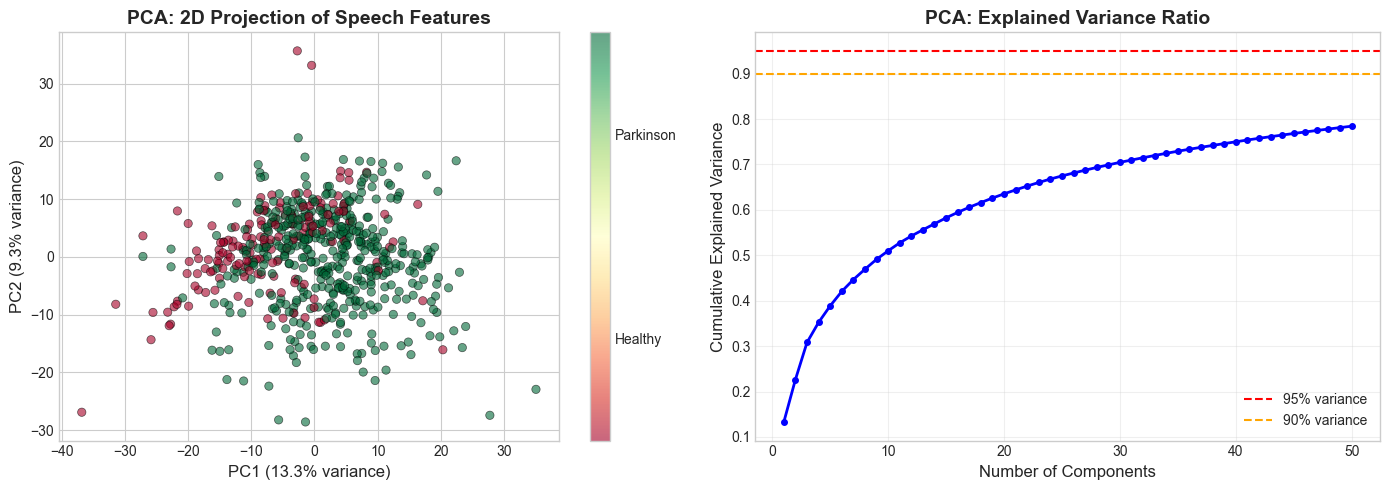


Number of components for 95% variance: 1


In [13]:
# PCA for visualization (2D)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

# Visualize PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2D scatter plot
ax1 = axes[0]
scatter = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_train, 
                      cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax1.set_title('PCA: 2D Projection of Speech Features', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(['Healthy', 'Parkinson'])

# Explained variance
pca_full = PCA(n_components=50)
pca_full.fit(X_train_scaled)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

ax2 = axes[1]
ax2.plot(range(1, 51), cumulative_var, 'b-', linewidth=2, marker='o', markersize=4)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('PCA: Explained Variance Ratio', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
print(f"\nNumber of components for 95% variance: {n_components_95}")

## 5. Model Training & Evaluation

In [14]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'Neural Network (MLP)': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=RANDOM_STATE, max_iter=500)
}

# Store results
results = {}

print("Training and Evaluating Models...")
print("=" * 70)

for name, model in models.items():
    print(f"\n>>> {name}")
    
    # Train
    model.fit(X_train_selected, y_train)
    
    # Predict
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='f1')
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"    Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    if roc_auc:
        print(f"    ROC AUC: {roc_auc:.4f} | CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Training and Evaluating Models...

>>> Logistic Regression
    Accuracy: 0.7895 | Precision: 0.8716 | Recall: 0.8407 | F1: 0.8559
    ROC AUC: 0.8496 | CV F1: 0.8585 (+/- 0.0282)

>>> K-Nearest Neighbors
    Accuracy: 0.8618 | Precision: 0.8833 | Recall: 0.9381 | F1: 0.9099
    ROC AUC: 0.8951 | CV F1: 0.8973 (+/- 0.0091)

>>> Support Vector Machine
    Accuracy: 0.7829 | Precision: 0.9000 | Recall: 0.7965 | F1: 0.8451
    ROC AUC: 0.8850 | CV F1: 0.8686 (+/- 0.0289)

>>> Decision Tree
    Accuracy: 0.7500 | Precision: 0.8099 | Recall: 0.8673 | F1: 0.8376
    ROC AUC: 0.6388 | CV F1: 0.8680 (+/- 0.0232)

>>> Random Forest
    Accuracy: 0.8158 | Precision: 0.8346 | Recall: 0.9381 | F1: 0.8833
    ROC AUC: 0.9105 | CV F1: 0.9165 (+/- 0.0131)

>>> Gradient Boosting
    Accuracy: 0.8355 | Precision: 0.8438 | Recall: 0.9558 | F1: 0.8963
    ROC AUC: 0.9129 | CV F1: 0.9144 (+/- 0.0080)

>>> AdaBoost
    Accuracy: 0.8224 | Precision: 0.8707 | Recall: 0.8938 | F1: 0.8821
    ROC AUC: 0.8793 | 

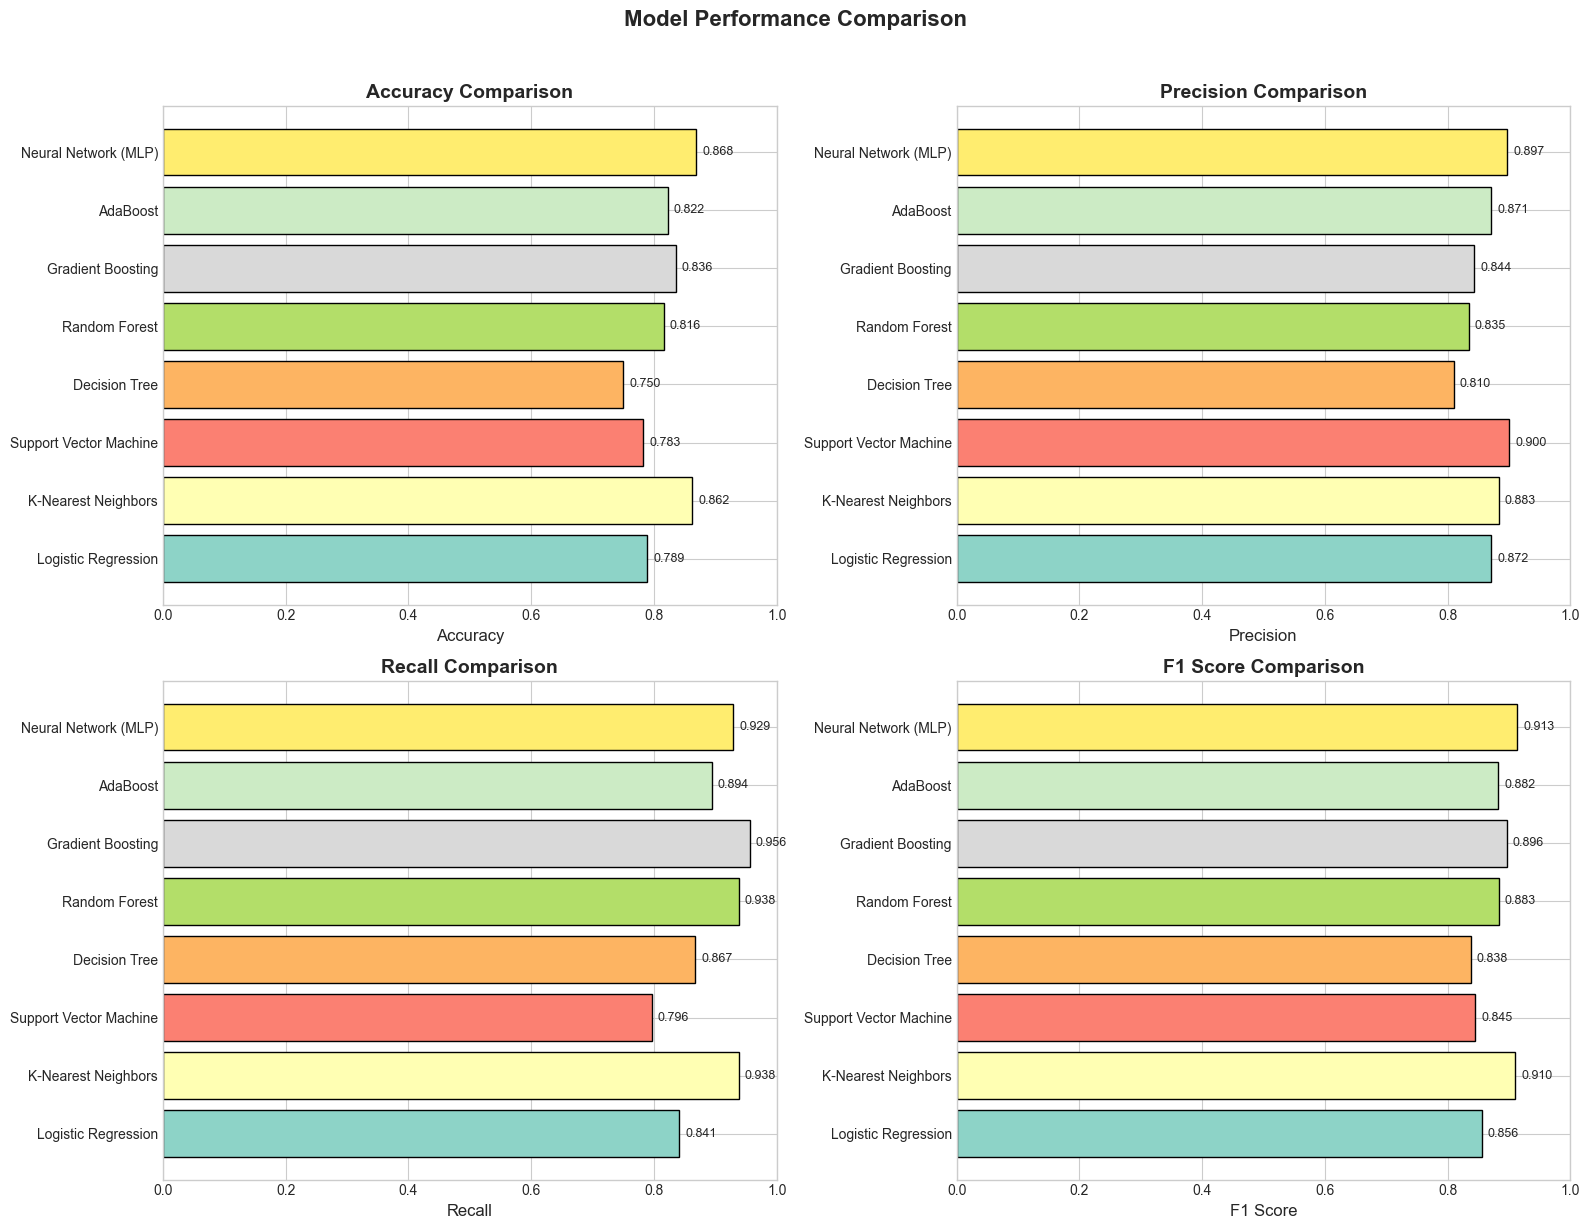

In [15]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))

for ax, metric, label in zip(axes.flatten(), metrics, metric_labels):
    values = [results[name][metric] for name in model_names]
    bars = ax.barh(model_names, values, color=colors, edgecolor='black')
    ax.set_xlabel(label, fontsize=12)
    ax.set_title(f'{label} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    
    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                va='center', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

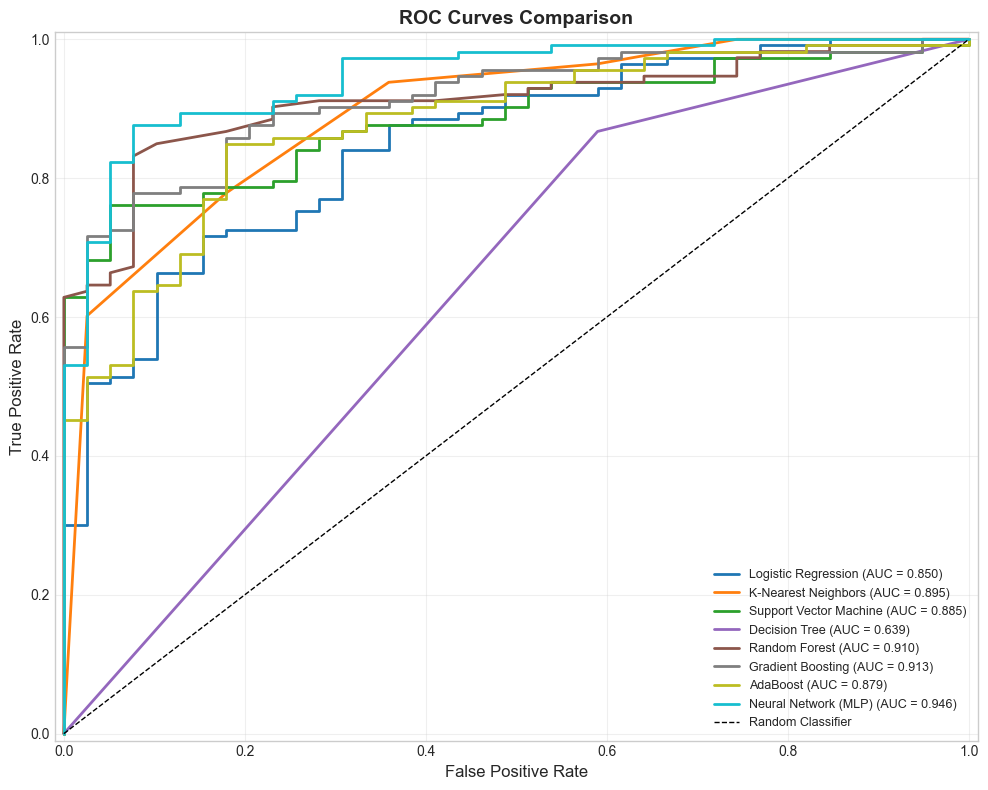

In [16]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for (name, result), color in zip(results.items(), colors):
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        ax.plot(fpr, tpr, color=color, linewidth=2, 
                label=f"{name} (AUC = {result['roc_auc']:.3f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])

plt.tight_layout()
plt.show()

Best Model: Neural Network (MLP)
F1 Score: 0.9130
Accuracy: 0.8684
ROC AUC: 0.9455


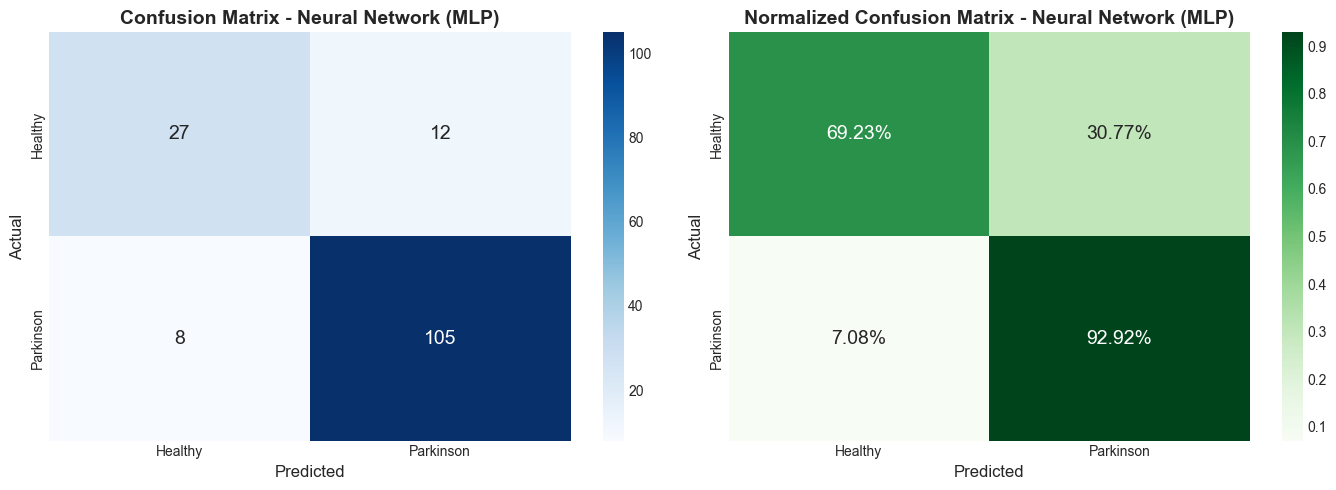


Detailed Classification Report:
              precision    recall  f1-score   support

     Healthy       0.77      0.69      0.73        39
   Parkinson       0.90      0.93      0.91       113

    accuracy                           0.87       152
   macro avg       0.83      0.81      0.82       152
weighted avg       0.87      0.87      0.87       152



In [18]:
# Find best model and display confusion matrix
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_result = results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"F1 Score: {best_result['f1']:.4f}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"ROC AUC: {best_result['roc_auc']:.4f}")

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, best_result['y_pred'])
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Healthy', 'Parkinson'],
            yticklabels=['Healthy', 'Parkinson'],
            annot_kws={'fontsize': 14})
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax2 = axes[1]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=ax2,
            xticklabels=['Healthy', 'Parkinson'],
            yticklabels=['Healthy', 'Parkinson'],
            annot_kws={'fontsize': 14})
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_title(f'Normalized Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(y_test, best_result['y_pred'], 
                           target_names=['Healthy', 'Parkinson']))

## 6. Hyperparameter Tuning (Best Model)

In [19]:
# Hyperparameter tuning for Random Forest
print("Hyperparameter Tuning for Random Forest...")
print("=" * 50)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

grid_search = GridSearchCV(
    rf, param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_selected, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")

Hyperparameter Tuning for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV F1 Score: 0.9186


In [20]:
# Evaluate tuned model
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test_selected)
y_pred_proba_tuned = best_rf.predict_proba(X_test_selected)[:, 1]

print("Tuned Random Forest Results:")
print("=" * 50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_tuned):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Healthy', 'Parkinson']))

Tuned Random Forest Results:
Accuracy:  0.8289
Precision: 0.8537
Recall:    0.9292
F1 Score:  0.8898
ROC AUC:   0.9074

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.72      0.54      0.62        39
   Parkinson       0.85      0.93      0.89       113

    accuracy                           0.83       152
   macro avg       0.79      0.73      0.75       152
weighted avg       0.82      0.83      0.82       152



## 7. Feature Importance Analysis

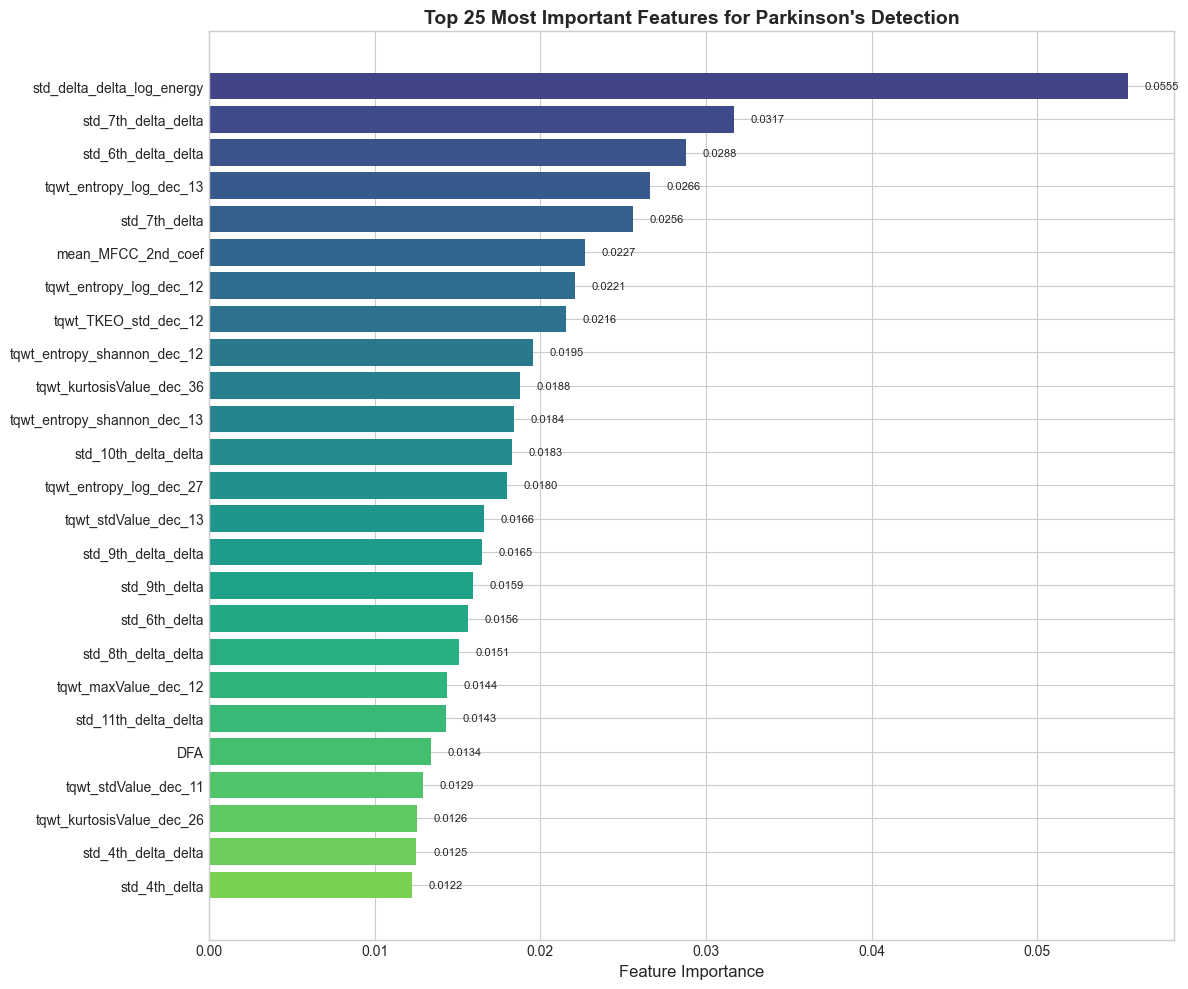


Top Features by Category:
std_delta_delta_log_energy                    (MFCC    ): 0.0555
std_7th_delta_delta                           (MFCC    ): 0.0317
std_6th_delta_delta                           (MFCC    ): 0.0288
tqwt_entropy_log_dec_13                       (TQWT    ): 0.0266
std_7th_delta                                 (MFCC    ): 0.0256
mean_MFCC_2nd_coef                            (MFCC    ): 0.0227
tqwt_entropy_log_dec_12                       (TQWT    ): 0.0221
tqwt_TKEO_std_dec_12                          (TQWT    ): 0.0216
tqwt_entropy_shannon_dec_12                   (TQWT    ): 0.0195
tqwt_kurtosisValue_dec_36                     (TQWT    ): 0.0188
tqwt_entropy_shannon_dec_13                   (TQWT    ): 0.0184
std_10th_delta_delta                          (MFCC    ): 0.0183
tqwt_entropy_log_dec_27                       (TQWT    ): 0.0180
tqwt_stdValue_dec_13                          (TQWT    ): 0.0166
std_9th_delta_delta                           (MFCC    ): 0.016

In [21]:
# Feature importance from tuned Random Forest
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 25 features
fig, ax = plt.subplots(figsize=(12, 10))

top_n = 25
top_features = feature_importance.head(top_n)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))

bars = ax.barh(range(top_n), top_features['importance'].values, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 25 Most Important Features for Parkinson\'s Detection', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, top_features['importance'].values):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print top features by category
print("\nTop Features by Category:")
print("=" * 60)
for feat, imp in zip(top_features['feature'].head(15), top_features['importance'].head(15)):
    # Determine category
    if 'tqwt' in feat.lower():
        cat = 'TQWT'
    elif 'mfcc' in feat.lower() or 'delta' in feat.lower() or 'energy' in feat.lower():
        cat = 'MFCC'
    elif any(x in feat for x in ['det_', 'app_', 'Ed', 'Ea']):
        cat = 'Wavelet'
    else:
        cat = 'Baseline'
    print(f"{feat:45s} ({cat:8s}): {imp:.4f}")

## 8. Final Summary & Results

In [22]:
# Create summary table
summary_data = []
for name, result in results.items():
    summary_data.append({
        'Model': name,
        'Accuracy': f"{result['accuracy']:.4f}",
        'Precision': f"{result['precision']:.4f}",
        'Recall': f"{result['recall']:.4f}",
        'F1 Score': f"{result['f1']:.4f}",
        'ROC AUC': f"{result['roc_auc']:.4f}" if result['roc_auc'] else 'N/A',
        'CV F1': f"{result['cv_mean']:.4f} (+/- {result['cv_std']:.4f})"
    })

summary_df = pd.DataFrame(summary_data)

print("=" * 100)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 100)
print(summary_df.to_string(index=False))

print("\n" + "*" * 100)
print("BEST MODEL RECOMMENDATION")
print("*" * 100)
print(f"\nRecommended Model: {best_model_name}")
print(f"Highest F1 Score: {best_result['f1']:.4f}")
print(f"Good balance between Precision ({best_result['precision']:.4f}) and Recall ({best_result['recall']:.4f})")
print(f"ROC AUC: {best_result['roc_auc']:.4f}")

print("\n Key Findings:")
print("1. The dataset is imbalanced (3:1 ratio of PD to Healthy)")
print("2. TQWT and MFCC features are most discriminative for PD detection")
print("3. Feature selection (100 features) improves model performance")
print("4. Ensemble methods (Random Forest, Gradient Boosting) perform best")

FINAL MODEL COMPARISON SUMMARY
                 Model Accuracy Precision Recall F1 Score ROC AUC               CV F1
   Logistic Regression   0.7895    0.8716 0.8407   0.8559  0.8496 0.8585 (+/- 0.0282)
   K-Nearest Neighbors   0.8618    0.8833 0.9381   0.9099  0.8951 0.8973 (+/- 0.0091)
Support Vector Machine   0.7829    0.9000 0.7965   0.8451  0.8850 0.8686 (+/- 0.0289)
         Decision Tree   0.7500    0.8099 0.8673   0.8376  0.6388 0.8680 (+/- 0.0232)
         Random Forest   0.8158    0.8346 0.9381   0.8833  0.9105 0.9165 (+/- 0.0131)
     Gradient Boosting   0.8355    0.8438 0.9558   0.8963  0.9129 0.9144 (+/- 0.0080)
              AdaBoost   0.8224    0.8707 0.8938   0.8821  0.8793 0.9032 (+/- 0.0164)
  Neural Network (MLP)   0.8684    0.8974 0.9292   0.9130  0.9455 0.9196 (+/- 0.0154)

****************************************************************************************************
BEST MODEL RECOMMENDATION
*******************************************************************